<a href="https://colab.research.google.com/github/linhnguyen222/DPS-Silo/blob/master/SeqTagMulticlass_Luna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Multi-class Sequence Tagging

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

In [1]:
!pip -q install trax==1.3.1

import trax 
from trax import layers as tl
import os 
import numpy as np
import pandas as pd
from pathlib import Path


#from pytorch_pretrained_bert import BertTokenizer
import torch
from pandas import DataFrame
import random as rnd

# set random seeds to make this notebook easier to replicate
trax.supervised.trainer_lib.init_random_number_generators(33)

     |████████████████████████████████| 348kB 2.8MB/s 
     |████████████████████████████████| 1.5MB 13.2MB/s 
     |████████████████████████████████| 174kB 16.9MB/s 
     |████████████████████████████████| 2.6MB 17.8MB/s 
     |████████████████████████████████| 5.3MB 38.3MB/s 
     |████████████████████████████████| 655kB 50.0MB/s 
     |████████████████████████████████| 983kB 46.1MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 348kB 54.9MB/s 
     |████████████████████████████████| 194kB 47.1MB/s 
     |████████████████████████████████| 368kB 51.5MB/s 
     |████████████████████████████████| 358kB 55.2MB/s 
     |████████████████████████████████| 1.1MB 54.7MB/s 
     |████████████████████████████████| 1.3MB 43.3MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
     |████████████████████████████████| 3.6MB 46.6MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 245kB 45.4MB/s 

DeviceArray([ 0, 33], dtype=uint32)

In [4]:
from google.colab import drive
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)
traindirectory = '/content/drive/My Drive/DSP/data/protechn_corpus_eval/train'
testdirectory = '/content/drive/My Drive/DSP/data/protechn_corpus_eval/test'
devdirectory = '/content/drive/My Drive/DSP/data/protechn_corpus_eval/dev'

Mounted at /content/drive


In [5]:
def read_data(directory):
    ids = []
    texts = []
    labels = []
    for f in directory.glob('*.txt'):
        id = f.name.replace('article', '').replace('.txt','')
        ids.append(id)
        texts.append(f.read_text())
        labels.append(parse_label(f.as_posix().replace('.txt', '.labels.tsv')))
    # labels can be empty 
    return ids, texts, labels

def clean_text(articles, ids):
    texts = []
    for article, id in zip(articles, ids):
        sentences = article.split('\n')
        start = 0
        end = -1
        res = []
        for sentence in sentences:
           start = end + 1
           end = start + len(sentence)  # length of sequence 
           if sentence != "": # if not empty line
               res.append([id, sentence, start, end])
        texts.append(res)
    return texts


def make_dataset(directory):
    ids, texts, labels = read_data(directory)
    texts = clean_text(texts, ids)
    res = []
    for text, label in zip(texts, labels):
        # making positive examples
        tmp = [] 
        pos_ind = [0] * len(text)
        for l in label:
            for i, sen in enumerate(text):
                if l[0] >= sen[2] and l[0] < sen[3] and l[1] > sen[3]:
                    l[4] = 1
                    tmp.append(sen + [l[0], sen[3], l[2], l[3], l[4]])
                    pos_ind[i] = 1
                    l[0] = sen[3] + 1
                elif l[0] != l[1] and l[0] >= sen[2] and l[0] < sen[3] and l[1] <= sen[3]: 
                    tmp.append(sen + l)
                    pos_ind[i] = 1
        # making negative examples
        dummy = [0, 0, 'O', 0, 0]
        for k, sen in enumerate(text):
            if pos_ind[k] != 1:
                tmp.append(sen+dummy)
        res.append(tmp)     
    return res

In [6]:
def parse_label(label_path):
    labels = []
    f= Path(label_path)
    
    if not f.exists():
        return labels

    for line in open(label_path):
        parts = line.strip().split('\t')
        labels.append([int(parts[2]), int(parts[3]), parts[1], 0, 0])
    labels = sorted(labels) 

    if labels:
        length = max([label[1] for label in labels]) 
        visit = np.zeros(length)
        res = []
        for label in labels:
            if sum(visit[label[0]:label[1]]):
                label[3] = 1
            else:
               visit[label[0]:label[1]] = 1
            res.append(label)
        return res 
    else:
        return labels

In [7]:
dataset=make_dataset(Path('/content/drive/My Drive/DSP/data/protechn_corpus_eval/train'))


In [74]:
empty=[]
for i in dataset:
    
    temp=DataFrame(i, columns=['id', 'full_sent', 'start_sent', 'end_sent', 'start_prop', 'end_prop','prop', 'ex1', 'ex2' ])
    empty.append(temp)

df=pd.concat(empty)  
df = df.drop(['ex1'],axis =1).drop(['ex2'],axis =1)
df.prop.value_counts()
df=df.reset_index()
#del df['index']

df.head()


,index,id,full_sent,start_sent,end_sent,start_prop,end_prop,prop
0,0,7618745059,“They interpreted the law in my case to say it...,1695,1873,1831,1872,Whataboutism
1,1,7618745059,Two guys on my ship did the same thing and wer...,1905,1977,1925,1976,Whataboutism
2,2,7618745059,“They used me as an example because of [the ba...,2312,2454,2312,2388,Causal_Oversimplification
3,3,7618745059,The government actively destroyed his life an ...,2710,2819,2725,2782,"Exaggeration,Minimisation"
4,4,7618745059,Ex-Sailor Pardoned By Trump Says He’s SUING Ob...,0,59,0,0,O


In [75]:
#We code the labels to integers
"""
possible_labels=df.prop.unique()
label_dict={}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label]=index
print(label_dict)
"""
label_dict={'O': 0, 'Black-and-White_Fallacy': 1, 'Loaded_Language': 2, 'Flag-Waving': 3, 
 'Name_Calling,Labeling': 4, 'Slogans': 5, 'Causal_Oversimplification': 6, 'Whataboutism': 7,
 'Exaggeration,Minimisation': 8, 'Doubt': 9, 'Appeal_to_Authority': 10, 'Repetition': 11, 'Appeal_to_fear-prejudice': 12,
 'Thought-terminating_Cliches': 13, 'Bandwagon': 14, 'Red_Herring': 15, 'Reductio_ad_hitlerum': 16,
 'Obfuscation,Intentional_Vagueness,Confusion': 17, 'Straw_Men': 18}

label_dict
df['label']=df.prop.replace(label_dict)


In [12]:
df.head()

,id,full_sent,start_sent,end_sent,start_prop,end_prop,prop,label
0,7618745059,“They interpreted the law in my case to say it...,1695,1873,1831,1872,Whataboutism,7
1,7618745059,Two guys on my ship did the same thing and wer...,1905,1977,1925,1976,Whataboutism,7
2,7618745059,“They used me as an example because of [the ba...,2312,2454,2312,2388,Causal_Oversimplification,6
3,7618745059,The government actively destroyed his life an ...,2710,2819,2725,2782,"Exaggeration,Minimisation",8
4,7618745059,Ex-Sailor Pardoned By Trump Says He’s SUING Ob...,0,59,0,0,O,0


In [76]:
df['binary']=10
#test
#df.at[1,'binary']=10
#this works
for i in range (0, 15752):
    if df.iloc[i]['label']==0  :
        
        df.at[i, 'binary']= 0 
    else:
        #False
        df.at[i, 'binary']= 1 


In [77]:
#we find length of sentence strings
df['sentence_length']=0
for i in range (0, 15752):
    df.at[i,'sentence_length']=df.iloc[i]['end_sent']-df.iloc[i]['start_sent'] 
        
        
 #we find length of propaganda token strings  
df['prop_length']=0
for i in range (0, 15752):
    df.at[i,'prop_length']=df.iloc[i]['end_prop']-df.iloc[i]['start_prop'] 
        

In [78]:
#df=pd.read_csv(Path("/content/export-train-seq"))
df.head()

,index,id,full_sent,start_sent,end_sent,start_prop,end_prop,prop,label,binary,sentence_length,prop_length
0,0,7618745059,“They interpreted the law in my case to say it...,1695,1873,1831,1872,Whataboutism,7,1,178,41
1,1,7618745059,Two guys on my ship did the same thing and wer...,1905,1977,1925,1976,Whataboutism,7,1,72,51
2,2,7618745059,“They used me as an example because of [the ba...,2312,2454,2312,2388,Causal_Oversimplification,6,1,142,76
3,3,7618745059,The government actively destroyed his life an ...,2710,2819,2725,2782,"Exaggeration,Minimisation",8,1,109,57
4,4,7618745059,Ex-Sailor Pardoned By Trump Says He’s SUING Ob...,0,59,0,0,O,0,0,59,0


For the purpose of sequence tagging a subset dataframe is formed from those sentences which hold a propaganda technique

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


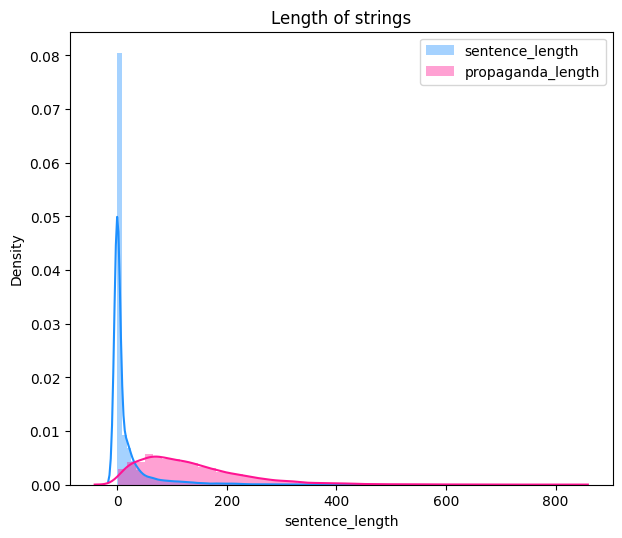

In [79]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(7,6), dpi=100)
sns.distplot( df['prop_length'] , color="dodgerblue", label="sentence_length")
#sns.distplot( df.loc[df.species=='virginica', "sepal_length"] , color="orange", label="virginica")
#sns.distplot( df.loc[df.species=='versicolor', "sepal_length"] , color="deeppink", label="versicolor")
sns.distplot( df['sentence_length'] , color="deeppink",  label="propaganda_length")

plt.title('Length of strings')
plt.legend();        
        

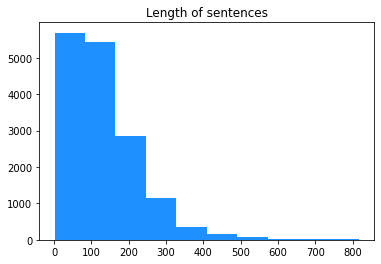

In [80]:

import matplotlib.pyplot as plt
plt.hist(df['sentence_length'], color="dodgerblue")
plt.title('Length of sentences')
plt.show()

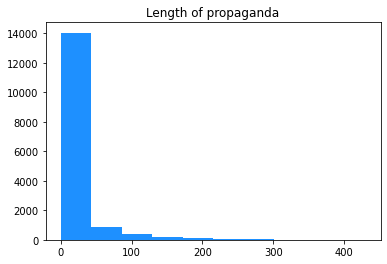

In [81]:

import matplotlib.pyplot as plt
plt.hist(df['prop_length'], color="dodgerblue")
plt.title('Length of propaganda')
plt.show()


In [82]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ['Attributes', 'Measures']
table.add_row(['Max of sentence length', df['sentence_length'].max()])
table.add_row(['Max of propaganda length', df['prop_length'].max()])
table.add_row(['Mean of sentence length', df['sentence_length'].mean()])
table.add_row(['Mean of propaganda length', df['prop_length'].mean()])
table.add_row(['Min of sentence length', df['sentence_length'].min()])
table.add_row(['Min of propaganda length', df['prop_length'].min()])
print(table)

+---------------------------+--------------------+
|         Attributes        |      Measures      |
+---------------------------+--------------------+
|   Max of sentence length  |        817         |
|  Max of propaganda length |        430         |
|  Mean of sentence length  | 131.66404266124937 |
| Mean of propaganda length | 15.778821736922296 |
|   Min of sentence length  |         1          |
|  Min of propaganda length |         0          |
+---------------------------+--------------------+


In [56]:
#Now we make the exact same dataframe for test and validation folders 
dataset_test=make_dataset(Path('/content/drive/My Drive/DSP/data/protechn_corpus_eval/test'))
dataset_dev=make_dataset(Path('/content/drive/My Drive/DSP/data/protechn_corpus_eval/dev'))

In [83]:
#make test set
empty_test=[]
for i in dataset_test:
    
    temp=DataFrame(i, columns=['id', 'full_sent', 'start_sent', 'end_sent', 'start_prop', 'end_prop','prop', 'ex1', 'ex2' ])
    empty_test.append(temp)

df_test=pd.concat(empty_test)  
df_test = df_test.drop(['ex1'],axis =1).drop(['ex2'],axis =1)
df_test.head()
df_test.prop.value_counts()
df_test=df_test.reset_index()
#del df_test['index']

label_dict
df_test['label']=df_test.prop.replace(label_dict)
df_test['binary']=10
#df_test.at[1,'binary']=11

for i in range (0, 4490):
    if (df_test.iloc[i]['label']==0 ) :
        
        df_test.at[i, 'binary']= 0 
    else:
        #False
        df_test.at[i, 'binary']= 1 
#df_test.head(15)

In [84]:
only_prop_df=df[(df["binary"] == 1)]
print("size of train is: ", only_prop_df.shape[0])
test_only_prop_df=df_test[(df_test["binary"] == 1)]
print("size of test is: ", test_only_prop_df.shape[0])

size of train is:  5415
size of test is:  1490


In [85]:
    
      
def clean(test):
    
     return re.sub(r'''
               [,.;“”*:`/"@#-?!&_$()]+  # Accept one or more copies of punctuation
               \ *           # plus zero or more copies of a space,
               ''',
               " ",          # and replace it with a single space
               test, flags=re.VERBOSE).replace('[','').replace(']','')  

           
            

In [86]:
import re

In this part each sentence is tagged such that words that signal a string of propaganda technique  are tagged as that technique and the rest of words in that sentence are tagged as none. 

In [87]:
all_tagged=[]
"""Pad token is 21"""

for i in range (0, 5415):
    #number of training example in one tsv file-length of each tsv dataframe
    #length= list_data[i].shape[0]
    #temp= nltk.sent_tokenize(s1[i])
        
    sentstart= only_prop_df.iloc[i][3]
    sentend= only_prop_df.iloc[i][4]
    propstart= only_prop_df.iloc[i][5]
    propend= only_prop_df.iloc[i][6]
    #label
    propclass=only_prop_df.iloc[i][8]
    count=0
    if propstart !=sentstart:
        #begin=df.iloc[i][4]
        #end=df.iloc[i][5]
        if propend !=sentend:
            begin= propstart-sentstart
            #proplength=propend_propstart   this is the length of the propaganda token
            end=propend-propstart+begin
            #beginstring.append(only_prop_df.iloc[i][2][:begin])
            length1=len(clean(only_prop_df.iloc[i][2][:begin]).split())
            begintag=[0]*length1
            
            #this is the substring that should be tagged
            length2=len(clean(only_prop_df.iloc[i][2][begin:end]).split())
            #midstring.append(clean(only_prop_df.iloc[i][2][begin:end]).split()
            midtag=[propclass]*length2

            
            length3=len(clean(only_prop_df.iloc[i][2][end:]).split())
            endtag=[0]*length3
            
            all_tagged.append(begintag+midtag+endtag)
                  
        else:
            
            begin= propstart-sentstart
            #proplength=propend_propstart   this is the length of the propaganda token
            #end=propend-propstart+begin
            length1=len(clean(only_prop_df.iloc[i][2][:begin]).split())
            begintag=[0]*length1
            # this is what should be tagged
            midstring=[]  
            length2=len(clean(only_prop_df.iloc[i][2][begin:]).split())
            midtag=[propclass]*length2
            
            all_tagged.append(begintag+midtag)

            
    else:
        
        if  propend !=sentend:
            
                    
            #begin= propstart-sentstart
            begin=0
            #proplength=propend_propstart   this is the length of the propaganda token
            end=propend-propstart
            #this is the substring that should be tagged
            length1=len(clean(only_prop_df.iloc[i][2][:end]).split())
            begintag=[propclass]*length1
            
            length2=len(clean(only_prop_df.iloc[i][2][end:]).split())
            endtag=[0]*length2
            all_tagged.append(begintag+endtag)

        else:  
                       
            length= len(clean(only_prop_df.iloc[i][2]).split())
            tag=[propclass]*length
            all_tagged.append(tag)


        

In [88]:
print(all_tagged[0])
print("size of all taged sentences from training set is:", len(all_tagged))
assert len(all_tagged)==(len(only_prop_df))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7]
size of all taged sentences from training set is: 5415


The tag_map corresponds to one of the possible tags a word can have. The cell below highlights the  classes that will be predicting. 

In [89]:
tag_map= {'0': 0, 'Black-and-White_Fallacy': 1, 'Loaded_Language': 2, 'Flag-Waving': 3,
  'Name_Calling,Labeling': 4, 'Slogans': 5, 'Causal_Oversimplification': 6, 'Whataboutism': 7, 'Exaggeration,Minimisation': 8,
  'Doubt': 9, 'Appeal_to_Authority': 10, 'Repetition': 11, 'Appeal_to_fear-prejudice': 12, 'Thought-terminating_Cliches': 13,
  'Bandwagon': 14, 'Red_Herring': 15, 'Reductio_ad_hitlerum': 16, 'Obfuscation,Intentional_Vagueness,Confusion': 17, 'Straw_Men': 18}
 
 
full_sent= only_prop_df['full_sent'].tolist()
print(tag_map)
 

{'0': 0, 'Black-and-White_Fallacy': 1, 'Loaded_Language': 2, 'Flag-Waving': 3, 'Name_Calling,Labeling': 4, 'Slogans': 5, 'Causal_Oversimplification': 6, 'Whataboutism': 7, 'Exaggeration,Minimisation': 8, 'Doubt': 9, 'Appeal_to_Authority': 10, 'Repetition': 11, 'Appeal_to_fear-prejudice': 12, 'Thought-terminating_Cliches': 13, 'Bandwagon': 14, 'Red_Herring': 15, 'Reductio_ad_hitlerum': 16, 'Obfuscation,Intentional_Vagueness,Confusion': 17, 'Straw_Men': 18}


In [90]:
from string import punctuation


vocab_to_int is a dictionary that translates a word string to a unique number. Given a sentence,then it is possible to  represent it as an array of numbers translating with this dictionary.

We will create an index mapping dictionary in such a way that the frequently occurring words are assigned lower indexes.  Counter method from Collections library is used for this purpose. 


In [91]:
for i in range(0,5415):
    
    
    full_sent[i]=full_sent[i].lower()
    full_sent[i]=clean(full_sent[i])
    
    
#with space
all_text2 = ' '.join([c for c in full_sent if c not in punctuation])
#without space
all_text2 = ''.join([c for c in all_text2 if c not in punctuation])    
 
all_text2 = all_text2.split('\n')
all_text2 = ' '.join(all_text2)
words2=all_text2.split()
from collections import Counter

counts = Counter(words2)
vocab = sorted(counts, key=counts.get, reverse=True)

#print(vocab)
vocab_to_int = {word2: ii for ii, word2 in enumerate(vocab, 1)}
#print(vocab_to_int)
print('vocab["at"]:', vocab_to_int["at"])


vocab["at"]: 28


In [92]:
full_sent_split=[]
for i in range(0, 5415):
    full_sent_split.append(full_sent[i].split())
    
full_sent_ints = [] 

for i in range(5415):     
    full_sent_ints.append([vocab_to_int[word] for word in full_sent_split[i]])
    

In [93]:
print(len(full_sent_ints))
print(len(all_tagged))

5415
5415


In [94]:
vocab=vocab_to_int
tag_map=tag_map
t_sentences=full_sent_ints[:4500]
t_labels=all_tagged[:4500]
t_size=len(t_labels)
v_sentences=full_sent_ints[4500:5000]
v_labels=all_tagged[4500:5000]
v_size=len(v_labels)
test_sentences=full_sent_ints[5000:]
test_labels=all_tagged[5000:]
test_size=len(test_labels)



In [95]:
print(t_sentences[1])
print(t_labels[1])
print(t_size)

[121, 2308, 13, 87, 3901, 107, 1, 173, 258, 4, 1726, 962, 10, 1303]
[0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7]
4500


In [96]:
# Exploring information about the data
print('The number of outputs in tag_map is: ', len(tag_map))
# The number of vocabulary tokens (including <PAD>)
g_vocab_size = len(vocab)
print(f"Num of vocabulary words: {g_vocab_size}")
print('The vocab size is:', len(vocab))
print('The training size is: ', t_size)
print('The validation size is: ', v_size)
print('An example of the first sentence is: ', t_sentences[0])
print('An example of its corresponding label is: ', t_labels[0])

The number of outputs in tag_map is:  19
Num of vocabulary words: 11665
The vocab size is: 11665
The training size is:  4500
The validation size is:  500
An example of the first sentence is:  [25, 3899, 1, 138, 6, 87, 146, 3, 177, 11, 17, 244, 1234, 120, 884, 159, 2065, 3, 3900, 307, 6, 16, 146, 30, 25, 620, 2899, 308, 147]
An example of its corresponding label is:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7]


In [97]:
# data_generator behaves like an iterator; it will return the next item 
def data_generator(batch_size, x, y, pad, shuffle=False, verbose=False):
    '''
      Output:
        a tuple containing 2 elements:
        X - np.ndarray of dim (batch_size, max_len) of padded sentences
        Y - np.ndarray of dim (batch_size, max_len) of tags associated with the sentences in X
    '''
    
    # count the number of lines in data_lines
    num_lines = len(x)
    
    # create an array with the indexes of data_lines that can be shuffled
    lines_index = [*range(num_lines)]
    
    # shuffle the indexes if shuffle is set to True
    if shuffle:
        rnd.shuffle(lines_index)
    
    index = 0 # tracks current location in x, y
    while True:
        buffer_x = [0] * batch_size # Temporal array to store the raw x data for this batch
        buffer_y = [0] * batch_size 
                
        
        
        # Find maximum length of sentences in x[index : index + batch_size] for this batch. 
        max_len = 0
        for i in range(batch_size):
            if index >= num_lines:
                index = 0
                if shuffle:
                    rnd.shuffle(lines_index)
            
            # The current position is obtained using `lines_index[index]`
            buffer_x[i] = x[lines_index[index]]
            
            # Store the y value at the current position into the buffer_y
            buffer_y[i] = y[lines_index[index]]
            
            lenx = len(x[lines_index[index]])     #length of current x[]
            if lenx > max_len:
                max_len = lenx                   #max_len tracks longest x[]
            
            # increment index by one
            index += 1


        # create X,Y, NumPy arrays of size (batch_size, max_len)
        X = np.full((batch_size, max_len), pad)
        Y = np.full((batch_size, max_len), pad)

        # copy values from lists to NumPy arrays. 
        for i in range(batch_size):
            # get the example (sentence as a tensor)
            x_i = buffer_x[i]
            
            # similarly, get the example's labels
            # in `buffer_y` at the `i` index
            y_i = buffer_y[i]
            
            # Walk through each word in x_i
            for j in range(len(x_i)):
                # store the word in x_i at position j into X
                X[i, j] = x_i[j]
                
                # store the label in y_i at position j into Y
                Y[i, j] = y_i[j]

        if verbose: print("index=", index)
        yield((X,Y))

In [98]:
batch_size = 5
mini_sentences = t_sentences[0: 8]
mini_labels = t_labels[0: 8]
dg = data_generator(batch_size, mini_sentences, mini_labels, 12121, shuffle=False, verbose=True)
X1, Y1 = next(dg)
X2, Y2 = next(dg)
print(Y1.shape, X1.shape, Y2.shape, X2.shape)
print(X1[0][:], "\n", Y1[0][:])

index= 5
index= 2
(5, 39) (5, 39) (5, 33) (5, 33)
[   25  3899     1   138     6    87   146     3   177    11    17   244
  1234   120   884   159  2065     3  3900   307     6    16   146    30
    25   620  2899   308   147 12121 12121 12121 12121 12121 12121 12121
 12121 12121 12121] 
 [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     7
     7     7     7     7     7 12121 12121 12121 12121 12121 12121 12121
 12121 12121 12121]


In [99]:

def NER(vocab_size=35181, d_model=50, tags=tag_map):
    '''
      Input: 
        vocab_size - integer containing the size of the vocabulary
        d_model - integer describing the embedding size
      Output:
        model - a serial model
    '''
    model = tl.Serial(
        tl.Embedding(vocab_size, d_model), # Embedding layer
     tl.LSTM(d_model), # LSTM layer
      tl.Dense(len(tags)), # Dense layer with len(tags) units
      tl.LogSoftmax()# LogSoftmax layer
      )
    return model

In [100]:
# initializing the model
model = NER()
# display the model
print(model)

Serial[
  Embedding_35181_50
  LSTM_50
  Dense_19
  LogSoftmax
]


In [101]:
from trax.supervised import training

rnd.seed(33)

batch_size = 64

# Create training data, mask pad id=12121 for training
train_generator = trax.supervised.inputs.add_loss_weights(
    data_generator(batch_size, t_sentences, t_labels, 12121, True),
    id_to_mask=12121)

# Create validation data, mask pad id=12121 for training
eval_generator = trax.supervised.inputs.add_loss_weights(
    data_generator(batch_size, v_sentences, v_labels, 12121, True),
    id_to_mask=12121)

In [102]:
# train_model
def train_model(NER, train_generator, eval_generator, train_steps=1, output_dir='model'):
    '''
    Input: 
        NER - the model you are building
        train_generator - The data generator for training examples
        eval_generator - The data generator for validation examples,
        train_steps - number of training steps
        output_dir - folder to save your model
    Output:
        training_loop - a trax supervised training Loop
    '''
    train_task = training.TrainTask(
      train_generator, # A train data generator
      loss_layer = tl.CrossEntropyLoss(), # A cross-entropy loss function
      optimizer = trax.optimizers.Adam(0.01),  # The adam optimizer
    )

    eval_task = training.EvalTask(
      labeled_data = eval_generator, # A labeled data generator
      metrics = [tl.CrossEntropyLoss(), tl.Accuracy()], # Evaluate with cross-entropy loss and accuracy
      n_eval_batches = 10 # Number of batches to use on each evaluation
    )

    training_loop = training.Loop(
        NER, # A model to train
        train_task, # A train task
        eval_task = eval_task, # The evaluation task
        output_dir = output_dir) # The output directory

    # Train with train_steps
    training_loop.run(n_steps = train_steps)
    return training_loop

In [103]:
train_steps = 100            
!rm -f 'model/model.pkl.gz'  # Remove old model.pkl if it exists

# Train the model
training_loop = train_model(NER(), train_generator, eval_generator, train_steps)

Step      1: train CrossEntropyLoss |  2.87387681
Step      1: eval  CrossEntropyLoss |  2.10846030
Step      1: eval          Accuracy |  0.67738598
Step    100: train CrossEntropyLoss |  1.25575161
Step    100: eval  CrossEntropyLoss |  1.35793239
Step    100: eval          Accuracy |  0.69012842


In [104]:
# loading in a pretrained model..
model = NER()
model.init(trax.shapes.ShapeDtype((1, 1), dtype=np.int32))

# Load the pretrained model
model.init_from_file('/content/model/model.pkl.gz', weights_only=True)

In [105]:
#Example of a comparision on a matrix 
a = np.array([1, 2, 3, 4])
a == 2

array([False,  True, False, False])

In [106]:
# create the evaluation inputs
x, y = next(data_generator(len(test_sentences), test_sentences, test_labels, 12121))
print("input shapes", x.shape, y.shape)

input shapes (415, 81) (415, 81)


In [107]:
# sample prediction
tmp_pred = model(x)
print(type(tmp_pred))
print(f"tmp_pred has shape: {tmp_pred.shape}")

<class 'jax.interpreters.xla.DeviceArray'>
tmp_pred has shape: (415, 81, 19)


In [108]:
#  evaluate_prediction
def evaluate_prediction(pred, labels, pad):
    """
    Inputs:
        pred: prediction array with shape 
            (num examples, max sentence length in batch, num of classes)
        labels: array of size (batch_size, seq_len)
        pad: integer representing pad character
    Outputs:
        accuracy: float
    """
    outputs = np.argmax(pred, axis=2)
    print("outputs shape:", outputs.shape)

    mask = labels !=pad
    print("mask shape:", mask.shape, "mask[0][20:30]:", mask[0][20:30])
    accuracy = np.sum(outputs == labels) / float(np.sum(mask))
    return accuracy

In [109]:
accuracy = evaluate_prediction(model(x), y, 12121)
print("accuracy: ", accuracy)

outputs shape: (415, 81)
mask shape: (415, 81) mask[0][20:30]: [ True  True  True  True  True  True  True  True  True  True]
accuracy:  0.6982142857142857


In [110]:
# Try the output for the introduction example
#sentence_for_Appeal_to_authority = "Only police and law knows about this"
#sentence_for_Doubt = "We are unsure as this is unclear how to be done"

sentence_for_exageration = "This policy is terribly very wrong"
#s = [vocab[token] if token in vocab else vocab['UNK'] for token in sentence.split(' ')]


In [111]:
from string import punctuation

def tokenize_sentence(test_sen):
    test_sen = test_sen.lower() # lowercase
    # get rid of punctuation
    test_text = ''.join([c for c in test_sen if c not in punctuation])

    # splitting by spaces
    test_words = test_text.split()

    # tokens
    test_ints = []
    test_ints.append([vocab_to_int[word] for word in test_words])

    return test_ints

# test code and generate tokenized review
test_sent = tokenize_sentence(sentence_for_exageration)
print(test_sent)

[[14, 624, 8, 7639, 103, 793]]
